<a href="https://colab.research.google.com/github/JunJul/NSDC-Project-Heart-Disease-Classification/blob/Master/Indicator_of_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## **Functions**

In [ ]:
# split the features into numerical and categorical features
def split_types(data):
  numerical_features = data.select_dtypes(["int64", "float64"])
  categorical_features = data.select_dtypes(["object", "category"])

  return numerical_features, categorical_features

# Encoding Functions
  # encode the categorical features into ordinal numbers
def ordinal_catfeatures_encoder(data):
  encoder = OrdinalEncoder()
  encoded_data = encoder.fit_transform(data)
  encoded_dataframe =  pd.DataFrame(encoded_data)
  encoded_dataframe.columns = data.columns

  return encoded_dataframe

  # one-hot encoding
def onehot_eoncoder(data):
  encoder = OneHotEncoder()
  encoded_data = encoder.fit_transform(data)
  encoded_dataframe = pd.DataFrame(encoded_data.toarray())

  return encoded_dataframe

  # Frequency encoding
def frequency_encoder(data, is_normalize = True):
  length = data.shape[1]
  columns = data.columns

  for i in range(length):
    frequency = data[columns[i]].value_counts(normalize=True)
    data[columns[i]] = data[columns[i]].map(frequency)

  return data;

# statsmodels for logistic Regression
def statsLogModel(x, y):
  x = sm.add_constant(x)
  statsLogitModel = sm.Logit(y, x).fit()

  return statsLogitModel

# plot the confusion matrix
def confusionMatrixPlot(cm):
    # cm = model.pred_table(threshold=0.5)
    cm_dis = ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])
    cm_dis.plot(cmap=plt.cm.Blues)

# scale data
def scale(x):
  scaler = StandardScaler()
  scaler.fit(x)
  scaled_x = scaler.transform(x)
  return scaled_x

# oversampling
def oversampling(x, y):
  ros = RandomOverSampler()
  x, y = ros.fit_resample(x, y)
  return x, y

# undersampling
def undersampling(x,y):
  rus = RandomUnderSampler()
  x, y = ros.fit_resample(x,y)
  return x, y

## **EDA**

In [ ]:
# import os
# from google.colab import files
# import shutil

# new_folder = "Data"

# if os.path.isdir(new_folder):
#   shutil.rmtree(new_folder)

# os.mkdir(new_folder)

# # Upload Files
# uploaded = files.upload()
# for filename in uploaded.keys():
#   dst_path = os.path.join(new_folder, filename)
#   print(f'move {filename} to {dst_path}')
#   shutil.move(filename, dst_path)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
data = pd.read_csv("/content/heart_2020_cleaned.csv")

In [ ]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [ ]:
data.HeartDisease.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [ ]:
data.shape

(319795, 18)

In [ ]:
data.columns.tolist()

['HeartDisease',
 'BMI',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'PhysicalHealth',
 'MentalHealth',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'SleepTime',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [ ]:
data.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

In [ ]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
response_feature = data.HeartDisease
predicted_features = data.drop("HeartDisease", axis=1)

In [ ]:
numerical_data, categorical_data = split_types(predicted_features)

In [ ]:
categorical_data = categorical_data.drop("AgeCategory", axis = 1)

In [ ]:
response_feature = response_feature.map({"Yes": 1, "No": 0})
response_feature.head()

0    0
1    0
2    0
3    0
4    0
Name: HeartDisease, dtype: int64

#### Multicollinearity

<Axes: >

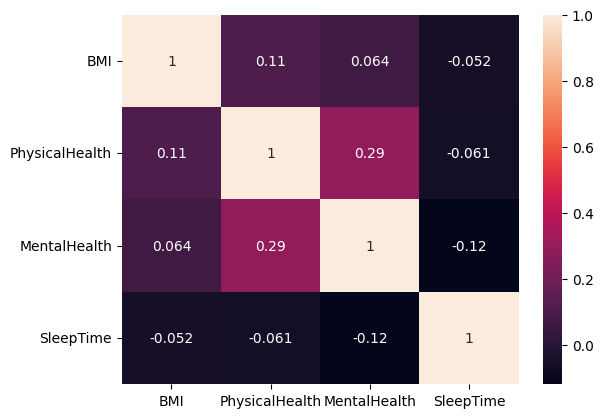

In [ ]:
numerical_corrleation = numerical_data.corr()
sns.heatmap(numerical_corrleation, annot=True)

In [ ]:
ordianlEncoded_categories = ordinal_catfeatures_encoder(categorical_data)

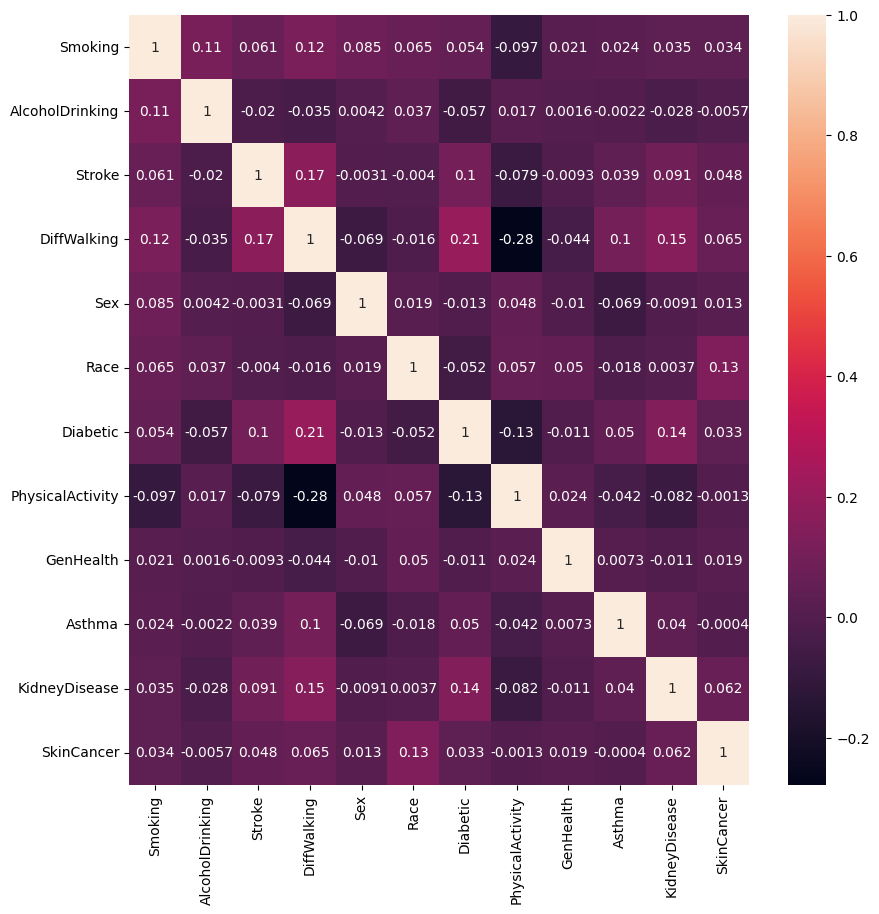

In [ ]:
correlation_cate = ordianlEncoded_categories.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_cate, annot=True)
plt.show()

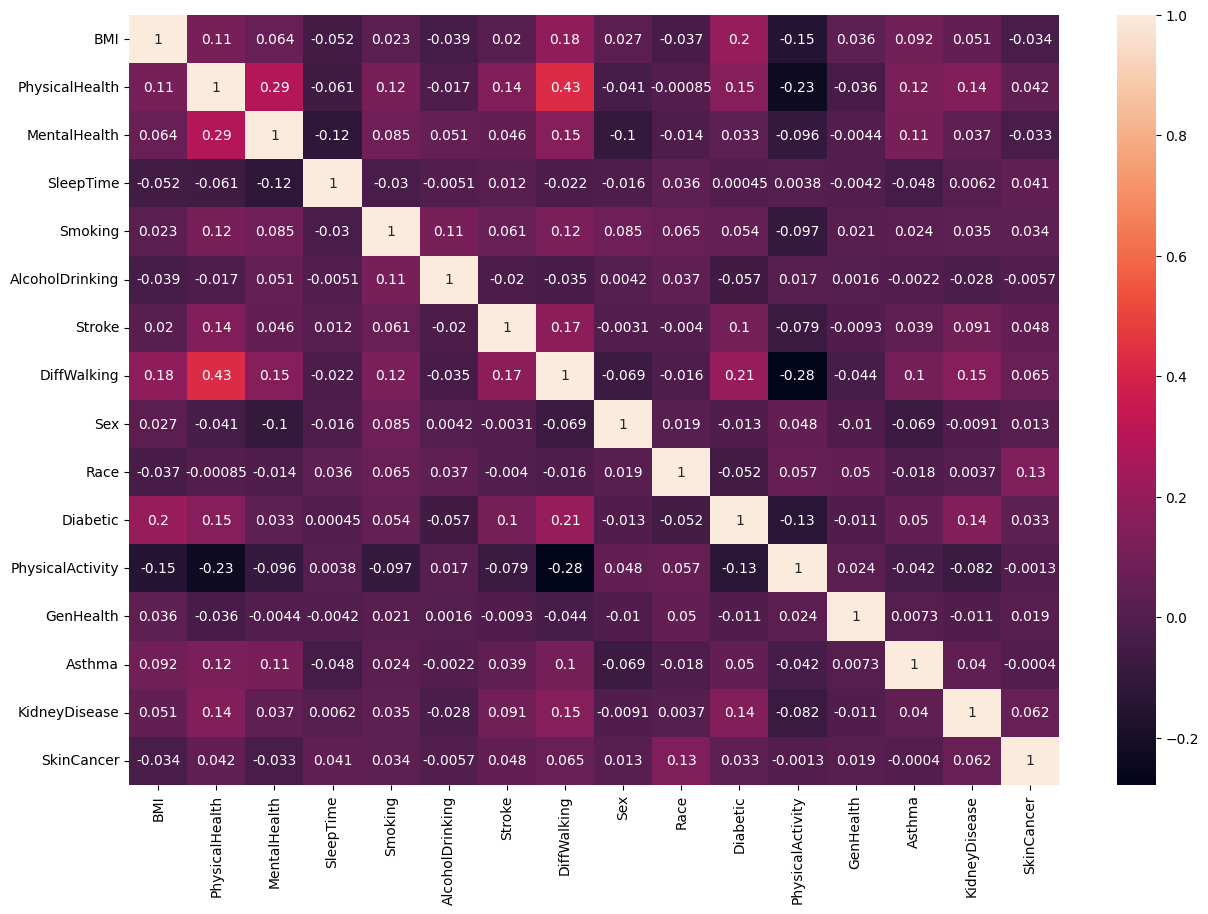

In [ ]:
correlation_numCate = pd.concat([numerical_data, ordianlEncoded_categories], axis = 1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_numCate, annot=True)
plt.show()

## StatsModels

### StatsModel1

In [ ]:
statsLogitModel1 = statsLogModel(ordianlEncoded_categories, response_feature)

Optimization terminated successfully.
         Current function value: 0.251308
         Iterations 7


In [ ]:
ordianlEncoded_categories.isnull().sum()

Smoking             0
AlcoholDrinking     0
Stroke              0
DiffWalking         0
Sex                 0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
statsLogitModel1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319782
Method:                           MLE   Df Model:                           12
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1400
Time:                        03:17:42   Log-Likelihood:                -80367.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.9151      0.035   -111.936      0.000      -3.984      -3.847
Smoking              0.5262      0.014     38.138      0.000       0.499       0.553
AlcoholDrinking     -0.4745      0.032    -14.601      0.000      -0.538      -0.411
Stroke               1.4121      0.022     63.427      0.000       1.368       1.456
DiffWalking          0.9208      0.016     56.675      0.000       0.889       0.953
Sex                  0.6207      0.014     44.508      0.000       0.593       0.648
Race                 0.1190      0.006     18.924      0.000       0.107       0.131
Diabetic             0.4197      0.008     55.028      0.000       0.405       0.435
PhysicalActivity    -0.2629      0.015    -17.142      0.000      -0.293      -0.233
GenHealth           -0.0095      0.005     -1.953      0.051      -0.019    3.48e-05
Asthma               0.1926      0.018     10.512      0.000       0.157       0.229
KidneyDisease        0.9169      0.024     37.996      0.000       0.870       0.964
SkinCancer           0.6178      0.019     32.917      0.000       0.581       0.655
====================================================================================
"""

(array([2.52356e+05, 3.94240e+04, 1.36560e+04, 5.60300e+03, 4.06600e+03,
        2.05900e+03, 1.22900e+03, 8.35000e+02, 4.17000e+02, 1.50000e+02]),
 array([0.00910043, 0.10188246, 0.19466448, 0.28744651, 0.38022853,
        0.47301056, 0.56579258, 0.65857461, 0.75135664, 0.84413866,
        0.93692069]),
 <BarContainer object of 10 artists>)

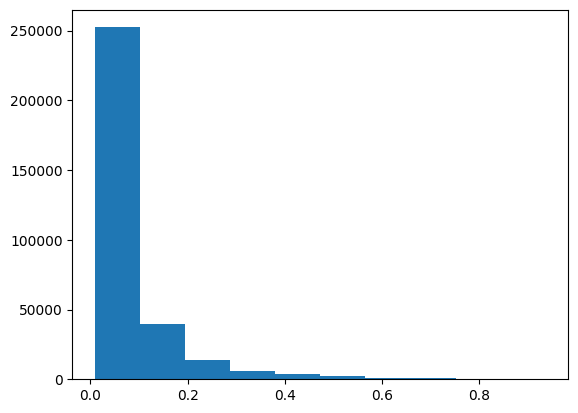

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel1.fittedvalues ))
plt.hist(proba)

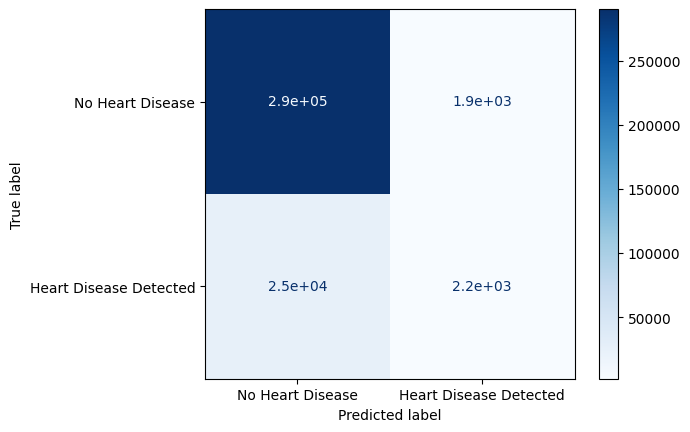

In [ ]:
cm1 = statsLogitModel1.pred_table(threshold=0.5)
confusionMatrixPlot(cm1)

### StatsModel2

In [ ]:
onehotencoded_categories = onehot_eoncoder(categorical_data)

In [ ]:
statsLogitModel2 = statsLogModel(onehotencoded_categories, response_feature)
statsLogitModel2.summary()

Optimization terminated successfully.
         Current function value: 0.242491
         Iterations 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319773
Method:                           MLE   Df Model:                           21
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1702
Time:                        03:17:45   Log-Likelihood:                -77548.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2409        nan        nan        nan         nan         nan
0             -0.3191        nan        nan        nan         nan         nan
1              0.0782        nan        nan        nan         nan         nan
2              0.1035        nan        nan        nan         nan         nan
3             -0.3444        nan        nan        nan         nan         nan
4             -0.7433        nan        nan        nan         nan         nan
5              0.5024        nan        nan        nan         nan         nan
6             -0.3691   1.38e+05  -2.68e-06      1.000    -2.7e+05     2.7e+05
7              0.1282   1.36e+05    9.4e-07      1.000   -2.67e+05    2.67e+05
8             -0.4212        nan        nan        nan         nan         nan
9              0.1803        nan        nan        nan         nan         nan
10             0.1298    2.1e+05   6.18e-07      1.000   -4.12e+05    4.12e+05
11            -0.4315    2.1e+05  -2.05e-06      1.000   -4.12e+05    4.12e+05
12            -0.0848   2.12e+05  -3.99e-07      1.000   -4.16e+05    4.16e+05
13            -0.2556    2.1e+05  -1.22e-06      1.000   -4.12e+05    4.12e+05
14             0.0750   2.08e+05   3.61e-07      1.000   -4.07e+05    4.07e+05
15             0.3262   2.08e+05   1.57e-06      1.000   -4.07e+05    4.07e+05
16            -0.2709   5.28e+04  -5.13e-06      1.000   -1.04e+05    1.04e+05
17             0.0669    5.3e+04   1.26e-06      1.000   -1.04e+05    1.04e+05
18             0.4349   5.34e+04   8.14e-06      1.000   -1.05e+05    1.05e+05
19            -0.4718   5.27e+04  -8.96e-06      1.000   -1.03e+05    1.03e+05
20            -0.0838        nan        nan        nan         nan         nan
21            -0.1571        nan        nan        nan         nan         nan
22            -1.1668   1.15e+05  -1.01e-05      1.000   -2.26e+05    2.26e+05
23             0.5327   1.15e+05   4.64e-06      1.000   -2.25e+05    2.25e+05
24             0.0644   1.15e+05    5.6e-07      1.000   -2.25e+05    2.25e+05
25             0.8796   1.15e+05   7.65e-06      1.000   -2.25e+05    2.25e+05
26            -0.5508   1.15e+05   -4.8e-06      1.000   -2.25e+05    2.25e+05
27            -0.1555   7.33e+04  -2.12e-06      1.000   -1.44e+05    1.44e+05
28            -0.0854   7.33e+04  -1.17e-06      1.000   -1.44e+05    1.44e+05
29            -0.4773        nan        nan        nan         nan         nan
30             0.2364        nan        nan        nan         nan         nan
31            -0.4097        nan        nan        nan         nan         nan
32             0.1688        nan        nan        nan         nan         nan
==============================================================================
"""

(array([2.37781e+05, 4.77460e+04, 1.57000e+04, 8.73200e+03, 4.08100e+03,
        2.58900e+03, 1.61400e+03, 9.36000e+02, 4.74000e+02, 1.42000e+02]),
 array([0.00354831, 0.09645871, 0.18936911, 0.28227951, 0.37518992,
        0.46810032, 0.56101072, 0.65392112, 0.74683153, 0.83974193,
        0.93265233]),
 <BarContainer object of 10 artists>)

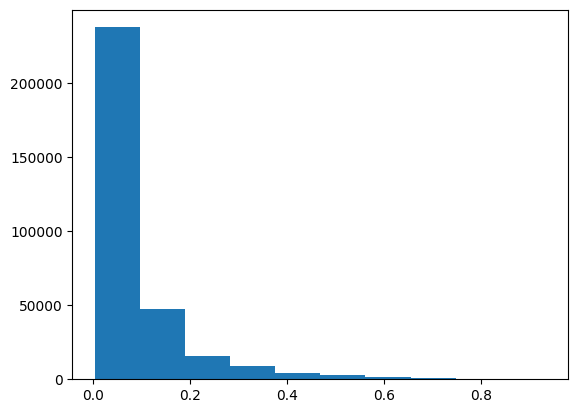

In [ ]:
plt.hist(1 / (1 + np.exp(- statsLogitModel2.fittedvalues )))

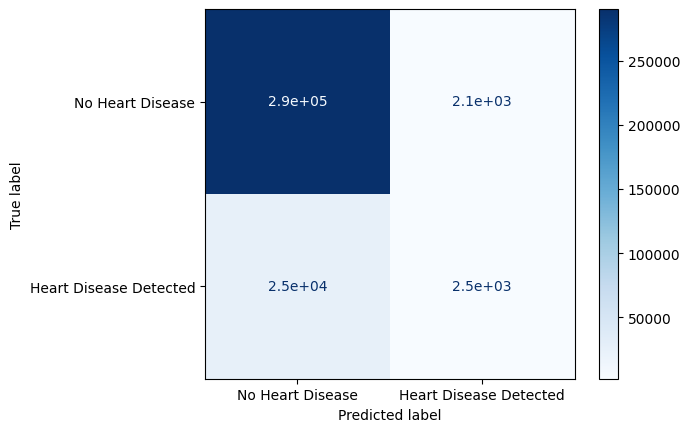

In [ ]:
cm2 = statsLogitModel2.pred_table(threshold=0.5)
confusionMatrixPlot(cm2)

### StatsModel3

In [ ]:
frequency_encoeded_cate = frequency_encoder(categorical_data, True)

In [ ]:
statsLogitModel3 = statsLogModel(frequency_encoeded_cate, response_feature)
statsLogitModel3.summary()

Optimization terminated successfully.
         Current function value: 0.248685
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319782
Method:                           MLE   Df Model:                           12
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1490
Time:                        03:17:48   Log-Likelihood:                -79528.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.5608      0.156     61.099      0.000       9.254       9.868
Smoking             -2.8359      0.079    -35.748      0.000      -2.991      -2.680
AlcoholDrinking      0.5460      0.038     14.460      0.000       0.472       0.620
Stroke              -1.4534      0.024    -59.705      0.000      -1.501      -1.406
DiffWalking         -0.9865      0.024    -41.388      0.000      -1.033      -0.940
Sex                -12.3470      0.283    -43.579      0.000     -12.902     -11.792
Race                 0.5892      0.025     23.267      0.000       0.540       0.639
Diabetic            -1.0587      0.021    -50.632      0.000      -1.100      -1.018
PhysicalActivity    -0.3423      0.028    -12.072      0.000      -0.398      -0.287
GenHealth           -2.8959      0.071    -40.857      0.000      -3.035      -2.757
Asthma              -0.1940      0.025     -7.659      0.000      -0.244      -0.144
KidneyDisease       -0.8980      0.026    -34.085      0.000      -0.950      -0.846
SkinCancer          -0.7535      0.023    -32.452      0.000      -0.799      -0.708
====================================================================================
"""

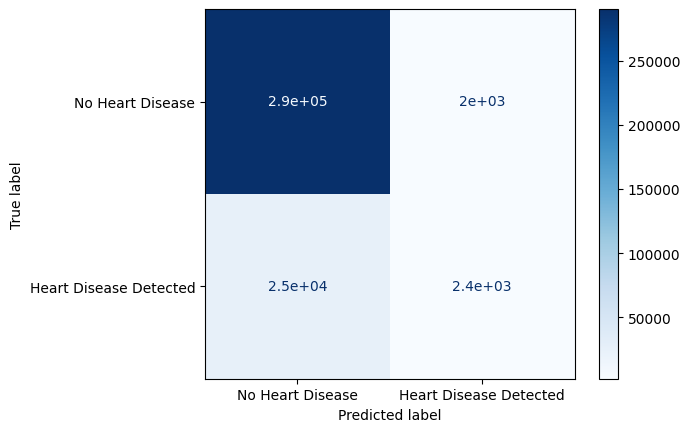

In [ ]:
cm3 = statsLogitModel3.pred_table(threshold=0.5)
confusionMatrixPlot(cm3)

#### The numerical variables + one hot encoded categorical variables

In [ ]:
statsLogitModel4 = statsLogModel(pd.concat([numerical_data,
                                            onehotencoded_categories], axis = 1),
                                 response_feature)
statsLogitModel4.summary()

Optimization terminated successfully.
         Current function value: 0.241903
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319769
Method:                           MLE   Df Model:                           25
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1722
Time:                        03:17:50   Log-Likelihood:                -77359.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.2138        nan        nan        nan         nan         nan
BMI               -0.0093      0.001     -8.713      0.000      -0.011      -0.007
PhysicalHealth     0.0028      0.001      3.226      0.001       0.001       0.004
MentalHealth      -0.0130      0.001    -15.084      0.000      -0.015      -0.011
SleepTime          0.0243      0.004      5.836      0.000       0.016       0.032
0                 -0.3076   9.14e+04  -3.37e-06      1.000   -1.79e+05    1.79e+05
1                  0.0938   9.15e+04   1.02e-06      1.000   -1.79e+05    1.79e+05
2                  0.1086        nan        nan        nan         nan         nan
3                 -0.3224        nan        nan        nan         nan         nan
4                 -0.7237        nan        nan        nan         nan         nan
5                  0.5098        nan        nan        nan         nan         nan
6                 -0.3629        nan        nan        nan         nan         nan
7                  0.1491        nan        nan        nan         nan         nan
8                 -0.4000        nan        nan        nan         nan         nan
9                  0.1861        nan        nan        nan         nan         nan
10                 0.1433   5.13e+04    2.8e-06      1.000   -1.01e+05    1.01e+05
11                -0.4567   5.14e+04  -8.88e-06      1.000   -1.01e+05    1.01e+05
12                -0.0771    5.1e+04  -1.51e-06      1.000   -9.99e+04    9.99e+04
13                -0.2497   5.16e+04  -4.84e-06      1.000   -1.01e+05    1.01e+05
14                 0.0992   5.17e+04   1.92e-06      1.000   -1.01e+05    1.01e+05
15                 0.3272   5.12e+04   6.39e-06      1.000      -1e+05       1e+05
16                -0.2824        nan        nan        nan         nan         nan
17                 0.0786        nan        nan        nan         nan         nan
18                 0.4384        nan        nan        nan         nan         nan
19                -0.4484        nan        nan        nan         nan         nan
20                -0.0656        nan        nan        nan         nan         nan
21                -0.1482        nan        nan        nan         nan         nan
22                -1.2017        nan        nan        nan         nan         nan
23                 0.5587        nan        nan        nan         nan         nan
24                 0.0675        nan        nan        nan         nan         nan
25                 0.9281        nan        nan        nan         nan         nan
26                -0.5665        nan        nan        nan         nan         nan
27                -0.1604   1.13e+05  -1.41e-06      1.000   -2.22e+05    2.22e+05
28                -0.0534   1.14e+05   -4.7e-07      1.000   -2.23e+05    2.23e+05
29                -0.4588        nan        nan        nan         nan         nan
30                 0.2450        nan        nan        nan         nan         nan
31  

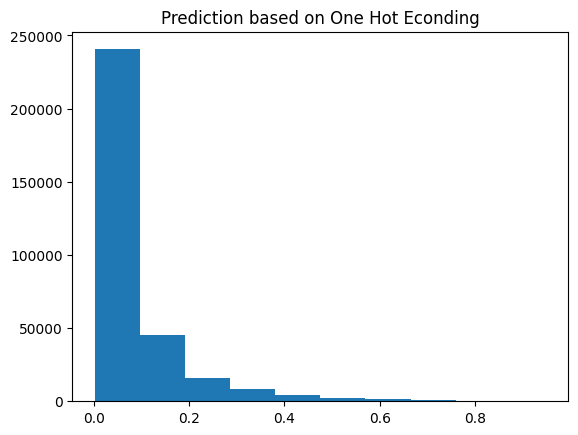

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel4.fittedvalues))
plt.hist(proba)
plt.title("Prediction based on One Hot Econding")
plt.show()

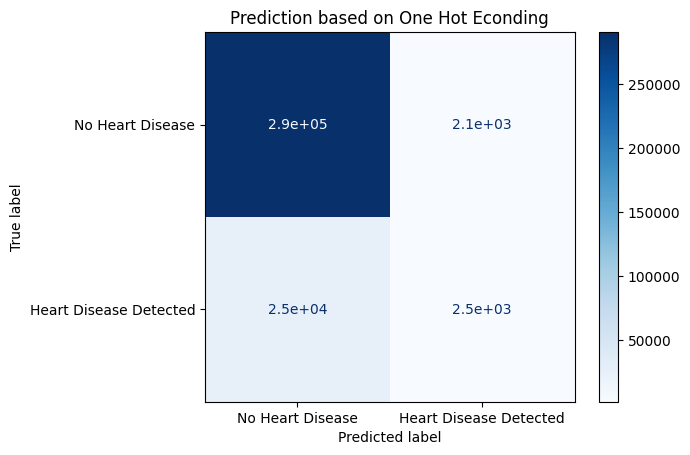

In [ ]:
cm4 = statsLogitModel4.pred_table(threshold=0.5)
confusionMatrixPlot(cm4)
plt.title("Prediction based on One Hot Econding")
plt.show()

### The numerical variables + ordianl encoded categorical variables

In [ ]:
statsLogitModel5 = statsLogModel(pd.concat([numerical_data,
                                            ordianlEncoded_categories], axis = 1),
                                 response_feature)
statsLogitModel5.summary()

Optimization terminated successfully.
         Current function value: 0.250012
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:               319795
Model:                          Logit   Df Residuals:                   319778
Method:                           MLE   Df Model:                           16
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                  0.1445
Time:                        03:17:52   Log-Likelihood:                -79953.
converged:                       True   LL-Null:                       -93453.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.0470      0.056    -72.583      0.000      -4.156      -3.938
BMI                 -0.0020      0.001     -1.850      0.064      -0.004       0.000
PhysicalHealth       0.0217      0.001     28.943      0.000       0.020       0.023
MentalHealth        -0.0075      0.001     -8.844      0.000      -0.009      -0.006
SleepTime            0.0208      0.004      4.958      0.000       0.013       0.029
Smoking              0.5127      0.014     36.932      0.000       0.485       0.540
AlcoholDrinking     -0.4629      0.033    -14.204      0.000      -0.527      -0.399
Stroke               1.3787      0.022     61.540      0.000       1.335       1.423
DiffWalking          0.7608      0.018     42.948      0.000       0.726       0.795
Sex                  0.6146      0.014     43.780      0.000       0.587       0.642
Race                 0.1153      0.006     18.298      0.000       0.103       0.128
Diabetic             0.4136      0.008     52.904      0.000       0.398       0.429
PhysicalActivity    -0.2126      0.016    -13.593      0.000      -0.243      -0.182
GenHealth           -0.0076      0.005     -1.556      0.120      -0.017       0.002
Asthma               0.1733      0.019      9.324      0.000       0.137       0.210
KidneyDisease        0.8660      0.024     35.633      0.000       0.818       0.914
SkinCancer           0.6038      0.019     31.980      0.000       0.567       0.641
====================================================================================
"""

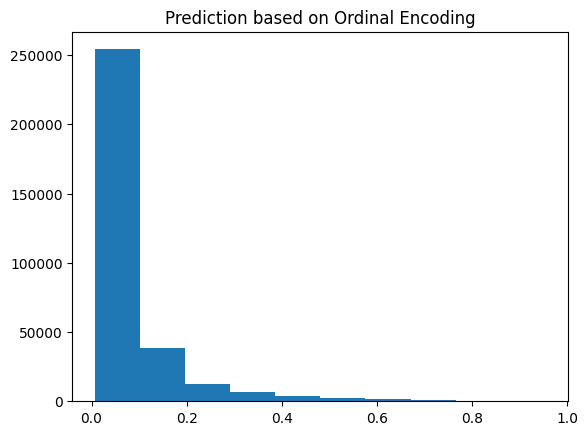

In [ ]:
proba = 1 / (1 + np.exp(- statsLogitModel5.fittedvalues))
plt.hist(proba)
plt.title("Prediction based on Ordinal Encoding")
plt.show()

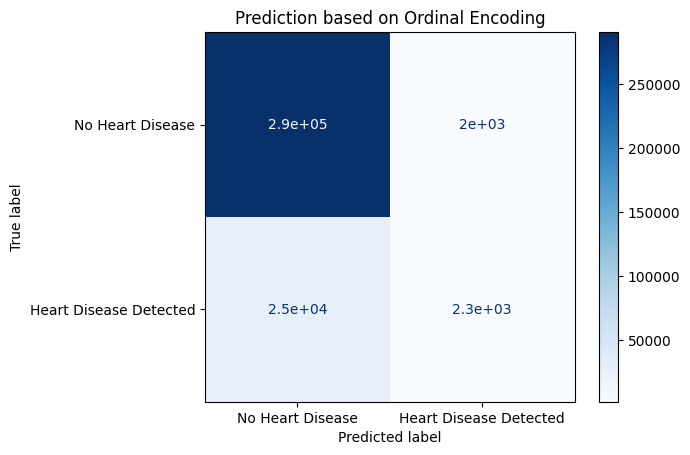

In [ ]:
cm5 = statsLogitModel5.pred_table(threshold = 0.5)
confusionMatrixPlot(cm5)
plt.title("Prediction based on Ordinal Encoding")
plt.show()

# Feature Engineering


## Feature Engineering Functions

In [ ]:
# Feature Engineering
# defining BMI categories option 2

def calculate_walkingspeed(age):
  if 20<=age<=29:
          return 1.35
          #featured_heartDisease.at[index, "Walking Speed"]=1.35
  elif 30<=age<=39:
          return 1.385
          # featured_heartDisease.at[index, "Walking Speed"]=1.385
  elif 40<=age<=49:
          return 1.41
           # featured_heartDisease.at[index, "Walking Speed"]=1.41
  elif 50<=age<=59:
          return 1.37
           # featured_heartDisease.at[index, "Walking Speed"]=1.37
  elif 60<=age<=69:
          return 1.29
           # featured_heartDisease.at[index, "Walking Speed"]=1.29
  elif 70<=age<=79:
          return 1.195
            #featured_heartDisease.at[index, "Walking Speed"]=1.195
  elif 80<=age<=89:
          return .955
          ## featured_heartDisease.at[index, "Walking Speed"]=.955

## BMI Distinction

In [ ]:
featured_heartDisease = data.copy()

featured_heartDisease['BMI_Distinction'] = pd.cut(
    featured_heartDisease['BMI'],
    bins= [0,18.5, 24.9, 29.9,34.9,39.9, float('inf')],
    labels=["Underweight", "Normal Weight", "Overweight",
            "Class I Obesity","Class II Obesity", "Class III Obesity"]
    )

## Mean Age

In [ ]:
temp_data = data['AgeCategory'].copy()

# featured_heartDisease.loc[featured_heartDisease['AgeCategory'] == '80 or older', 'AgeCategory'] = 80
temp_data[temp_data == '80 or older'] = 80

split_val= temp_data.astype(str).str.split('-', expand=True)

convert_ind0 = split_val[0].astype(float)
convert_ind2 = split_val[1].astype(float)
convert_ind2 = convert_ind2.fillna(80)

mean_val= (convert_ind0 + convert_ind2)/2
featured_heartDisease['MeanAge']= mean_val

In [ ]:
featured_heartDisease.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0


## Walking Speed

In [ ]:
#does same thing
#defining walking speeds
#iterate through dataFrame and set Walking Speeds based on age range
#dataset has difference in walking speed so  this is from the average walking speed by age link

featured_heartDisease['Walking_Speed'] = featured_heartDisease['MeanAge'].apply(calculate_walkingspeed)

In [ ]:
featured_heartDisease.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge,Walking_Speed
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,...,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0,1.370
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,...,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0,0.955
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,...,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0,1.290
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,...,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0,1.195
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,...,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0,1.410


In [ ]:
featured_heartDisease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   HeartDisease      319795 non-null  object  
 1   BMI               319795 non-null  float64 
 2   Smoking           319795 non-null  object  
 3   AlcoholDrinking   319795 non-null  object  
 4   Stroke            319795 non-null  object  
 5   PhysicalHealth    319795 non-null  float64 
 6   MentalHealth      319795 non-null  float64 
 7   DiffWalking       319795 non-null  object  
 8   Sex               319795 non-null  object  
 9   AgeCategory       319795 non-null  object  
 10  Race              319795 non-null  object  
 11  Diabetic          319795 non-null  object  
 12  PhysicalActivity  319795 non-null  object  
 13  GenHealth         319795 non-null  object  
 14  SleepTime         319795 non-null  float64 
 15  Asthma            319795 non-null  object  
 16  Ki

In [ ]:
new_numerical_features, new_categorical_fetaures = split_types(featured_heartDisease)

y = new_categorical_fetaures.HeartDisease
new_categorical_fetaures = new_categorical_fetaures.drop("HeartDisease", axis=1)

In [ ]:
new_ordianl_encoded_cateFeatures = ordinal_catfeatures_encoder(new_categorical_fetaures)
encoded_featured_heartDisease = pd.concat([new_numerical_features, new_ordianl_encoded_cateFeatures], axis=1)

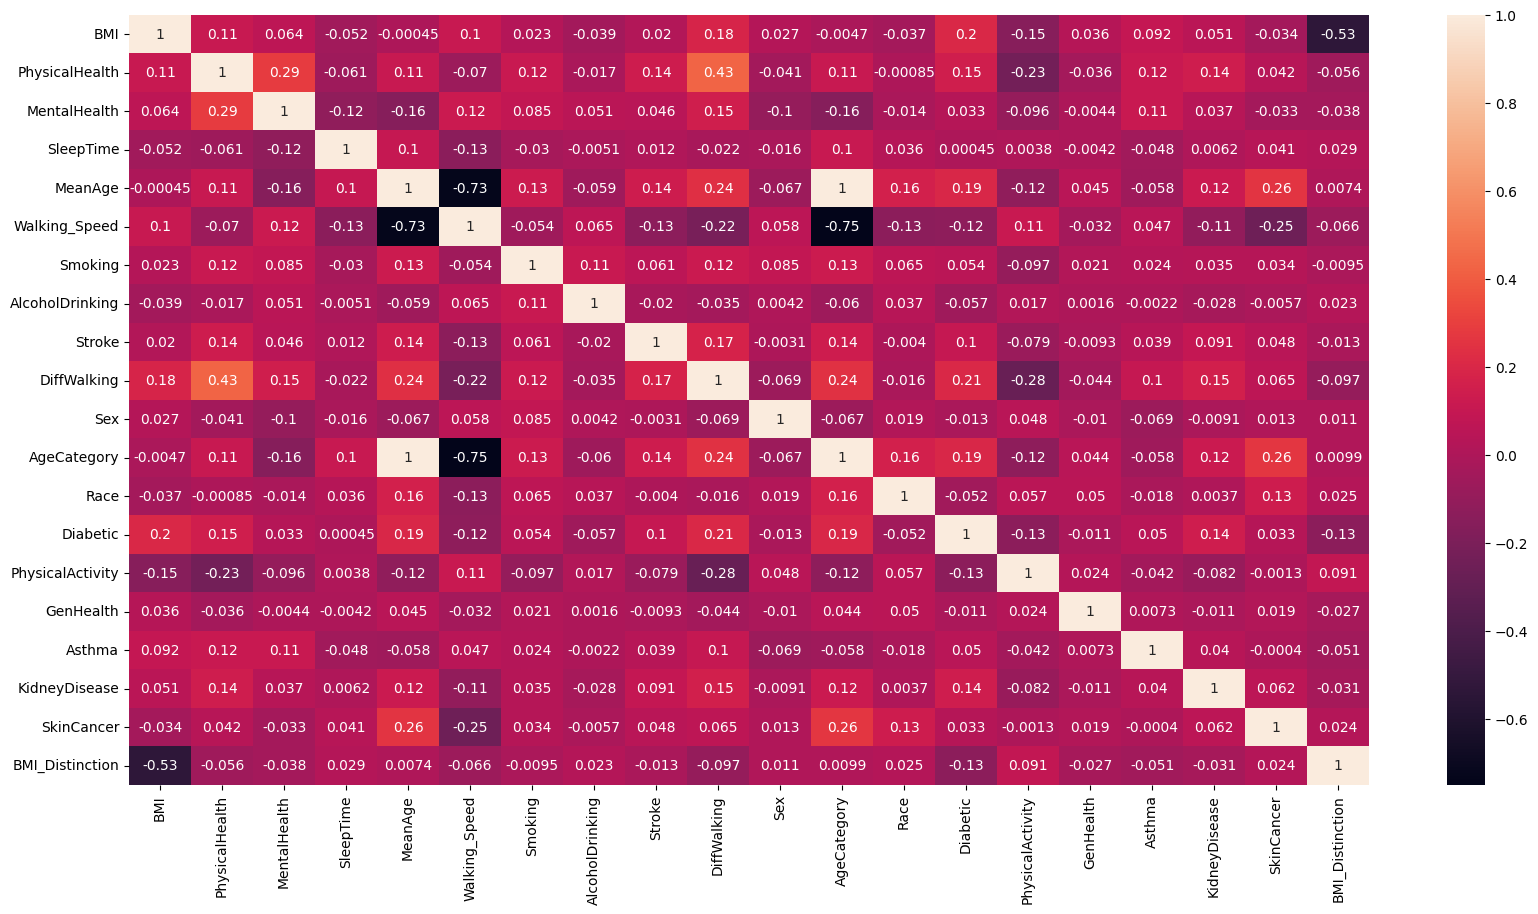

In [ ]:
correlation = encoded_featured_heartDisease.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True)
plt.show()

## Data Preprocessing

In [ ]:
# No missing values (no check)

#For checking for missing values (there are none as the non-null count is the same through all categories).
heartDisease = data.copy()
heartDisease.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [ ]:
response_feature = heartDisease["HeartDisease"]
response_feature.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [ ]:
# split categorical features and numerical features into different variables
numerical_data, categorical_data = split_types(heartDisease)
categorical_data = categorical_data.drop("HeartDisease", axis = 1)

In [ ]:
response_feature.head()

0    No
1    No
2    No
3    No
4    No
Name: HeartDisease, dtype: object

In [ ]:
# sns.heatmap(numerical_data)
numerical_data.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime
0,16.60,3.0,30.0,5.0
1,20.34,0.0,0.0,7.0
2,26.58,20.0,30.0,8.0
3,24.21,0.0,0.0,6.0
4,23.71,28.0,0.0,8.0


In [ ]:
categorical_data.head()

,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


In [ ]:
categorical_data.nunique()

Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Race                 6
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        2
SkinCancer           2
dtype: int64

<Axes: >

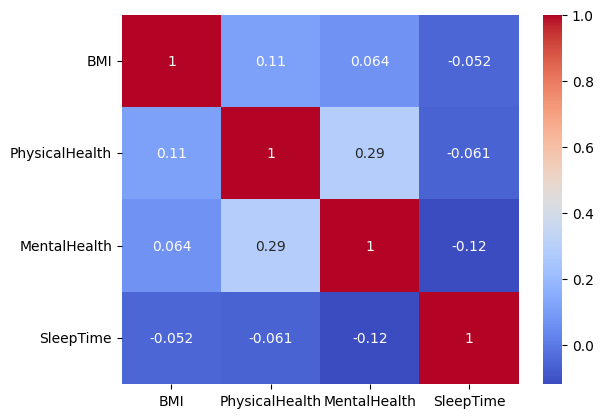

In [ ]:
#heatmap checking for collinearity of numerical dadta
sns.heatmap(numerical_data.corr(), cmap='coolwarm', annot=True)

In [ ]:
# encode categorical features
# categorical_data_encoded = frequency_encoder(categorical_data)
# categorical_data_encoded = onehot_eoncoder(categorical_data)
categorical_data_encoded = ordinal_catfeatures_encoder(categorical_data)

In [ ]:
#encode response feature
response_feature_encoded = response_feature.map({"Yes": 1, "No": 0})

In [ ]:
# concat numerical and categorical data
predicted_variables = pd.concat([numerical_data,
                                         categorical_data_encoded], axis=1)
predicted_variables.columns = predicted_variables.columns.astype(str)

In [ ]:
predicted_variables_ros, response_feature_encoded_ros = oversampling(predicted_variables, response_feature_encoded)

In [ ]:
# Split
train_x, test_x, train_y, test_y = train_test_split(predicted_variables_ros,
                                                    response_feature_encoded_ros, test_size=0.2, shuffle=True)

In [ ]:
# Scale
train_scaled_x = scale(train_x)
test_scaled_x = scale(test_x)

In [ ]:
# Oversampling for train
# train_x_scaled_ros, train_y_ros = oversampling(train_scaled_x, train_y)
# train_y_ros.value_counts()
print(train_y.value_counts())
test_y.value_counts()

0    233952
1    233923
Name: HeartDisease, dtype: int64


1    58499
0    58470
Name: HeartDisease, dtype: int64

In [ ]:
#random under sampling
predicted_variables_rus, response_feature_encoded_rus = undersampling(predicted_variables, response_feature_encoded)

In [ ]:
#Split
train_x_rus, test_x_rus, train_y_rus, test_y_rus = train_test_split(predicted_variables_rus, response_feature_encoded_rus, test_size=0.2, shuffle=True)

In [ ]:
# Scale
train_scaled_x_rus = scale(train_x_rus)
test_scaled_x_rus = scale(test_x_rus)

In [ ]:
print(train_y_rus.value_counts())
test_y_rus.value_counts()

## Model

In [ ]:
# XGBClassifier
classifier = XGBClassifier(n_estimators=100, learning_rate=0.05)
classifier.fit(
    train_scaled_x, train_y,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
predictions = classifier.predict(test_scaled_x)

In [ ]:
accuracy = accuracy_score(predictions, test_y)
accuracy

0.6952953346613205

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
validation_score = cross_val_score(classifier, train_scaled_x, train_y, cv=cv)

Shuffled Validation Mean Accuracy: 77.12%
              precision    recall  f1-score   support

           0       0.63      0.73      0.67     50487
           1       0.76      0.67      0.71     66482

    accuracy                           0.70    116969
   macro avg       0.70      0.70      0.69    116969
weighted avg       0.70      0.70      0.70    116969



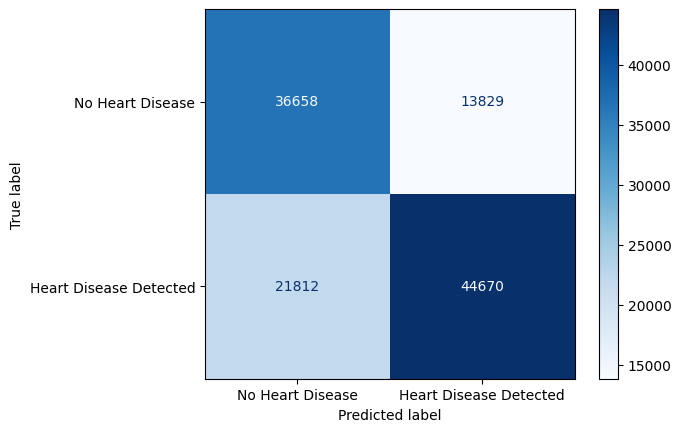

In [ ]:
cm = confusion_matrix(predictions, test_y)
cm_dis = ConfusionMatrixDisplay(cm, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(validation_score.mean()*100))
print(cm_dis.plot(cmap=plt.cm.Blues))
print(classification_report(predictions, test_y))

In [ ]:
#XGB Classifier undersampling
classifier_rus = XGBClassifier(n_estimators=100, learning_rate=0.05)
classifier_rus.fit(
    train_scaled_x_rus, train_y_rus,
    verbose=False
)

In [ ]:
predictions_rus = classifier_rus.predict(test_scaled_x_rus)

In [ ]:
accuracy_rus = accuracy_score(predictions_rus, test_y_rus)
accuracy_rus

In [ ]:
cv_rus = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
validation_score_rus = cross_val_score(classifier_rus, train_scaled_x_rus, train_y_rus, cv=cv_rus)

In [ ]:
cm_rus = confusion_matrix(predictions_rus, test_y_rus)
cm_dis_rus = ConfusionMatrixDisplay(cm_rus, display_labels=['No Heart Disease',
                                                        "Heart Disease Detected"])

In [ ]:
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(validation_score_rus.mean()*100))
print(cm_dis_rus.plot(cmap=plt.cm.Blues))
print(classification_report(predictions_rus, test_y_rus))

### Pipeline

In [ ]:
def pipelineModel(model, x_ros, y_ros, ordinalEncoder=True):
  cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
  train_x, test_x, train_y, test_y = train_test_split(
      x_ros,
      y_ros,
      test_size=0.2,
      shuffle=True
      )

  numerical_transformer = SimpleImputer(strategy="median")

  categorical_transformer = Pipeline(
      steps=[
      ("Imputer", SimpleImputer(strategy="most_frequent")),
      ("ordinal", OrdinalEncoder())
      ]
  )

  preprocessor = ColumnTransformer(
      transformers=[
          ("num", numerical_transformer, numerical_cols),
          ("cat", categorical_transformer, categorical_cols),
      ]
  )

  my_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
         ('scaler', StandardScaler()),
        ("model", model)
    ]
  )

  my_pipeline.fit(train_x, train_y)

  predictions = my_pipeline.predict(test_x)
  cm = confusion_matrix(predictions, test_y)
  report = classification_report(predictions, test_y)

  validation_score = cross_val_score(my_pipeline, train_x, train_y, cv=cv)

  return my_pipeline, cm, report, validation_score



In [ ]:
def splitCols(data):
  numerical_cols = [i for i in x.columns if x[i].dtype in ["int64", "float64"]]
  categorical_cols = [i for i in x.columns if x[i].dtype == "object"]
  return numerical_cols, categorical_cols

In [ ]:
# def cross_validation(model, x, y):
#   cv = ShuffleSplit(n_splits=5, test_size = 0.2, random_state=0)
#   validation= cross_val_score(model, x, y, cv = cv)
#   return validation

In [ ]:
y = heartDisease.copy().HeartDisease
x = heartDisease.copy().drop("HeartDisease", axis=1)

In [ ]:
numerical_cols, categorical_cols = splitCols(x)
y = y.map({"No": 0, "Yes":1})
x_ros, y_ros = oversampling(x, y)

In [ ]:
# RandomForestClassifier
# n_estimator: how many trees in the model which has a series of decision trees
rfc_model = RandomForestClassifier(n_estimators=35)
rfc_pipeline, rfc_cm, rfc_report, rfc_validation_score = pipelineModel(rfc_model, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 95.90%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54884
           1       1.00      0.94      0.97     62085

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



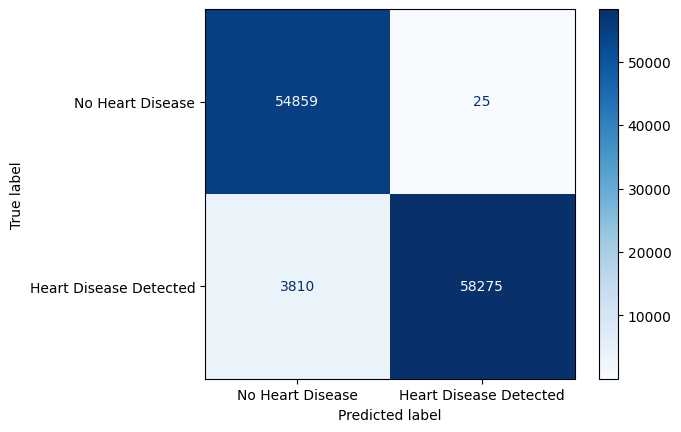

In [ ]:
confusionMatrixPlot(rfc_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(rfc_validation_score.mean()*100))
print(rfc_report)

In [ ]:
# DecisionTrees with a tree
# max_depth: the depth of a tree
model_dt = DecisionTreeClassifier(max_depth=35, random_state=1234)
dt_pipeline, dt_cm, dt_report, dt_validation_score = pipelineModel(model_dt, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 96.02%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54467
           1       1.00      0.94      0.97     62502

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



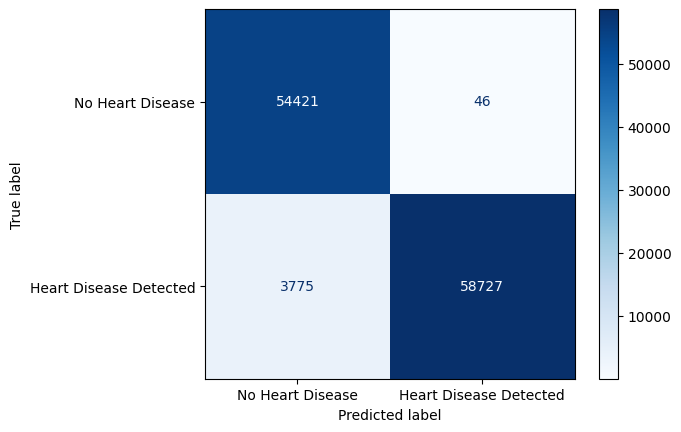

In [ ]:
confusionMatrixPlot(dt_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(dt_validation_score.mean()*100))
print(dt_report)

In [ ]:
# Logistic Regression
model_lr = LogisticRegression(C=0.5, random_state=1234)
lr_pipeline, lr_cm, lr_report, lr_validation_score = pipelineModel(model_lr, x_ros, y_ros)

Shuffled Validation Mean Accuracy: 75.11%
              precision    recall  f1-score   support

           0       0.74      0.76      0.75     56864
           1       0.77      0.75      0.76     60105

    accuracy                           0.75    116969
   macro avg       0.75      0.75      0.75    116969
weighted avg       0.75      0.75      0.75    116969



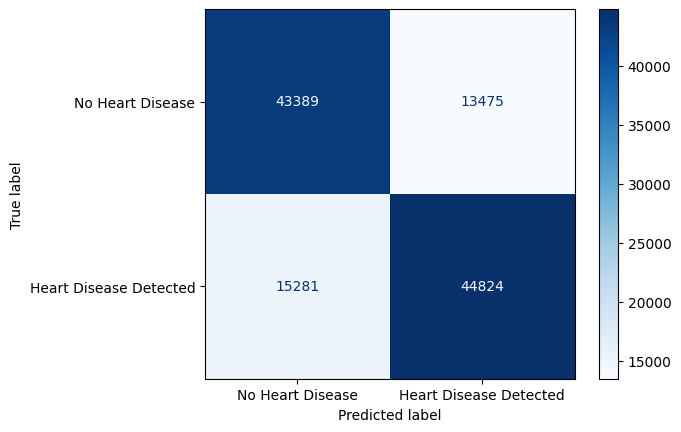

In [ ]:
confusionMatrixPlot(lr_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(lr_validation_score.mean()*100))
print(lr_report)

### Model with added more features

In [ ]:
x_added_features = featured_heartDisease.drop('HeartDisease', axis=1).copy()
x_added_features_ros, y_added_features_ros = oversampling(x_added_features, y)
y_added_features_ros.value_counts()

0    292422
1    292422
Name: HeartDisease, dtype: int64

In [ ]:
x_added_features_ros.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,BMI_Distinction,MeanAge,Walking_Speed
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Underweight,57.0,1.370
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,Normal Weight,80.0,0.955
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,Overweight,67.0,1.290
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,Normal Weight,77.0,1.195
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,Normal Weight,42.0,1.410


In [ ]:
added_features_rfc_pipeline, added_features_rfc_cm, added_features_rfc_report, added_features_rfc_validation_score = pipelineModel(
    RandomForestClassifier(n_estimators=30),
    x_added_features_ros,
    y_added_features_ros
)

Shuffled Validation Mean Accuracy: 96.09%
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     54912
           1       1.00      0.94      0.97     62057

    accuracy                           0.97    116969
   macro avg       0.97      0.97      0.97    116969
weighted avg       0.97      0.97      0.97    116969



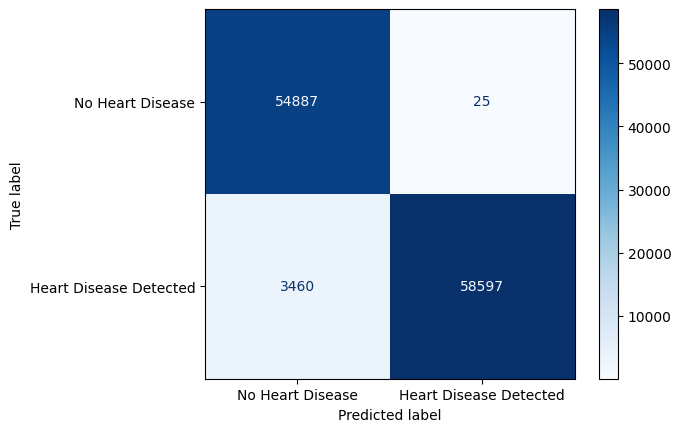

In [ ]:
confusionMatrixPlot(added_features_rfc_cm)
print("Shuffled Validation Mean Accuracy: {:.2f}%".format(added_features_rfc_validation_score.mean()*100))
print(added_features_rfc_report)